# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [264]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import metrics
from scipy.stats import ks_2samp

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [18]:
def analise_bi_quali(df, var_resposta, 
                      var_explicativa, 
                      nomes_colunas={0: 'saudavel', 1: 'doente'}, 
                      nomes_index=None):

    # Tabela cruzada com totais
    tabela = pd.crosstab(df[var_explicativa], df[var_resposta], margins=True)

    # Renomear colunas
    tabela.rename(columns={**nomes_colunas, 'All': 'Total flag_doente'}, inplace=True)
    # Renomear índices
    if nomes_index:
        tabela.rename(index={**nomes_index, 'All': 'Todos'}, inplace=True)
    else:
        tabela.rename(index={'All': 'Todos'}, inplace=True)

    # Cálculos protegidos contra divisão por zero
    with np.errstate(divide='ignore', invalid='ignore'):
        tabela['media_doente'] = tabela['doente'] / tabela['Total flag_doente']
        tabela['odds'] = tabela['doente'] / tabela['saudavel']
        tabela['OR_vs_total'] = tabela['odds'] / tabela.loc['Todos', 'odds']
        tabela['Logito'] = np.log(tabela['odds'].replace(0, np.nan))
        tabela['WOE'] = np.log(tabela['OR_vs_total'].replace(0, np.nan))

    return tabela

In [20]:
biv_slope = analise_bi_quali(df, 'flag_doente', 'slope')
biv_slope

flag_doente,saudavel,doente,Total flag_doente,media_doente,odds,OR_vs_total,Logito,WOE
slope,,,,,,,,
1.0,106,36,142,0.253521,0.339623,0.400706,-1.079920,-0.914528
2.0,49,91,140,0.650000,1.857143,2.191161,0.619039,0.784432
3.0,9,12,21,0.571429,1.333333,1.573141,0.287682,0.453075
Todos,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [22]:
biv_fps = analise_bi_quali(df, 'flag_doente', 'fbs')
biv_fps

flag_doente,saudavel,doente,Total flag_doente,media_doente,odds,OR_vs_total,Logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
Todos,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [24]:
biv_cp = analise_bi_quali(df, 'flag_doente', 'cp')
biv_cp

flag_doente,saudavel,doente,Total flag_doente,media_doente,odds,OR_vs_total,Logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
Todos,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


## Response

### The CP variable presents the greatest contrasts in odds, WOE and logit between the categories.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [329]:
def analise_bi_quant(df, var_resposta, 
                      var_explicativa, 
                      nomes_colunas={0: 'saudavel', 1: 'doente'}, 
                      nomes_index=None):
    
    # Definindo o valor default para 5
    faixa = pd.qcut(df[var_explicativa], 5, duplicates='drop')

    # Tabela cruzada com totais
    tabela = pd.crosstab(faixa, df[var_resposta], margins=True)

    # Renomear colunas
    tabela.rename(columns={**nomes_colunas, 'All': 'Total flag_doente'}, inplace=True)
    # Renomear índices
    if nomes_index:
        tabela.rename(index={**nomes_index, 'All': 'Todos'}, inplace=True)
    else:
        tabela.rename(index={'All': 'Todos'}, inplace=True)

    # Cálculos protegidos contra divisão por zero
    with np.errstate(divide='ignore', invalid='ignore'):
        tabela['media_doente'] = tabela['doente'] / tabela['Total flag_doente']
        tabela['odds'] = tabela['doente'] / tabela['saudavel']
        tabela['OR_vs_total'] = tabela['odds'] / tabela.loc['Todos', 'odds']
        tabela['Logito'] = np.log(tabela['odds'].replace(0, np.nan))
        tabela['WOE'] = np.log(tabela['OR_vs_total'].replace(0, np.nan))

    return tabela

In [331]:
bi_age = analise_bi_quant(df, 'flag_doente', 'age')
bi_age

flag_doente,saudavel,doente,Total flag_doente,media_doente,odds,OR_vs_total,Logito,WOE
age,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
Todos,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [334]:
reglog = smf.logit('flag_doente ~ sex + cp + trestbps + age', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                  0.2605
Time:                        22:47:53   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

In [336]:
odds_ratio_sex = np.exp(reglog.params.iloc[1])
print(f'Men are {odds_ratio_sex:.2f} times more likely to be sick than women')

#-------------------------------------------------------------------------------

odds_ratio_cp = np.exp(reglog.params.iloc[2])
print(f'People with a higher category of chest pain are {odds_ratio_cp:.2f} times more likely to get sick')

#-------------------------------------------------------------------------------

odds_ratio_trestbps = np.exp(reglog.params.iloc[3])
porcento = (odds_ratio_trestbps - 1)*100
print(f'For every 1 unit increase in blood pressure, the chance of being sick increases by {porcento:.2f}%')

#-------------------------------------------------------------------------------

odds_ratio_age = np.exp(reglog.params.iloc[4])
porcento_age = (odds_ratio_age - 1)*100
print(f'With each additional year of age, the chance of being sick increases by {porcento_age:.2f}%')

Men are 6.06 times more likely to be sick than women
People with a higher category of chest pain are 3.13 times more likely to get sick
For every 1 unit increase in blood pressure, the chance of being sick increases by 2.16%
With each additional year of age, the chance of being sick increases by 5.99%


## Summary analysis
### sex + cp + trestbps + age
- men are 6 times more likely to be sick than women
- people with a higher category of chest pain are 3.13 times more likely to get sick
- for every 1 unit increase in blood pressure, the chance of being sick increases by 2.16%
- with each additional year of age, the chance of being sick increases by 5.99%
- everyone the coefficients are statistically significative (p < 0.05)

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [340]:
# Adicionando uma coluna com a probabilidade de evento predita do modelo
df['predito_model'] = reglog.predict(df)

#-------------------------------------------------------------------------------

# Utilizando o qcut para dividir em 5 grupos
df_qcut = pd.qcut(df['predito_model'], 5, duplicates='drop')

#-------------------------------------------------------------------------------

# Calculando a médio do predito por grupo
df_groupby = df.groupby(df_qcut, observed=False)
df_media = (df_groupby[['predito_model']]
            .mean()
            .rename(columns={
                'predito_model':'media_predito'
            }))

#-------------------------------------------------------------------------------

# Criando a coluna para a taxa de eventos por grupo
df_media['media_doente'] = df_groupby['flag_doente'].mean()
df_media

,media_predito,media_doente
predito_model,,
"(0.0119, 0.146]",0.076255,0.098361
"(0.146, 0.349]",0.249060,0.183333
"(0.349, 0.575]",0.457982,0.491803
"(0.575, 0.772]",0.673059,0.683333
"(0.772, 0.928]",0.837449,0.836066


Text(0.5, 0, 'Grupos')

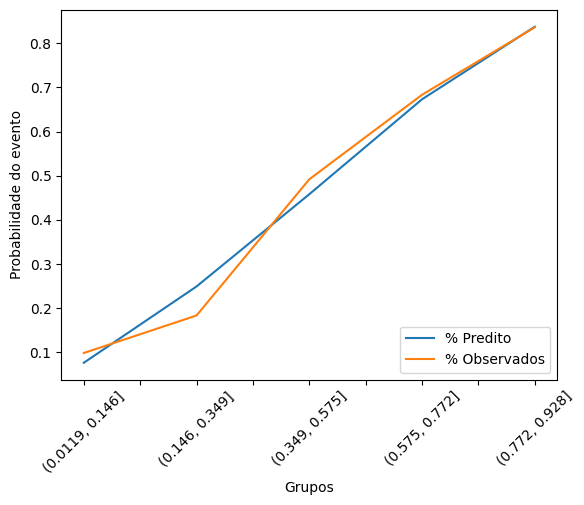

In [342]:
# Criando o gráfico para comparar a media_predito x media_doente

fig = plt.figure()  # Cria uma janela vazia onde se pode desenhar gráficos
ax = fig.add_subplot(1,1,1)  # layout de 1 linha x 1 coluna de subplots, está adicionando o primeiro (e único) subplot nessa figura

ax = df_media['media_predito'].plot(label='% Predito')
ax = df_media['media_doente'].plot(label='% Observados')

plt.xticks(rotation=45)
ax.legend(loc='lower right')  # Posição da legenda
ax.set_ylabel('Probabilidade do evento')
ax.set_xlabel('Grupos')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [381]:
# Acuracidade
acc = metrics.accuracy_score(df['flag_doente'],
                             df['predito_model']>.5)

#-------------------------------------------------------------------------------

# Para calcular o gini, primeiramente vou encontrar a curva ROC.
fpr, tpr, threshold = metrics.roc_curve(df['flag_doente'],
                             df['predito_model'])
auc_ = metrics.auc(fpr, tpr)
# Com a curva ROC encontrada, basta usar (2*auc_ - 1)
gini = 2*auc_ - 1

#-------------------------------------------------------------------------------

# KS
ks = ks_2samp(df.loc[df['flag_doente']==1,
              'predito_model'],
              df.loc[df['flag_doente']!=1,
              'predito_model']).statistic

print('Accuracy:{0:.2f}% \nKS:{1:.2f}% \nGini:{2:.2f}%'
      .format(acc*100, ks*100, gini*100))

Accuracy:77.89% 
KS:58.40% 
Gini:66.22%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

# We can improve...

## Using 'slope'

With slope
- Accuracy:78.22% 
- AUC:85.47% 
- Gini:70.94%

Without slope
- Accuracy:77.89% 
- AUC:83.11% 
- Gini:66.22%

There was an improvement in accuracy, AUC and gini.

In [350]:
new_reglog = smf.logit('flag_doente ~ sex + cp + trestbps + age + slope', data=df).fit()
new_reglog.summary()

Optimization terminated successfully.
         Current function value: 0.472334
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                  0.3152
Time:                        22:47:59   Log-Likelihood:                -143.12
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.013e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4607      1.745     -7.139      0.000     -15.882      -9.040
sex            1.8826      0.349      5.398      0.000       1.199       2.566
cp             1.1292      0.174      6.500      0.000       0.789       1.470
trestbps       0.0202      0.009      2.339      0.019       0.003       0.037
age            0.0515      0.018      2.865      0.004       0.016       0.087
slope          1.1392      0.249      4.575      0.000       0.651       1.627
==============================================================================
"""

In [377]:
ratio_sex = np.exp(new_reglog.params.iloc[1])
print(f'Men are {ratio_sex:.2f} times more likely to be sick than women')

#-------------------------------------------------------------------------------

ratio_cp = np.exp(new_reglog.params.iloc[2])
print(f'People with a higher category of chest pain are {ratio_cp:.2f} times more likely to get sick')

#-------------------------------------------------------------------------------

ratio_trestbps = np.exp(new_reglog.params.iloc[3])
cento = (odds_ratio_trestbps - 1)*100
print(f'For every 1 unit increase in blood pressure, the chance of being sick increases by {cento:.2f}%')

#-------------------------------------------------------------------------------

ratio_age = np.exp(new_reglog.params.iloc[4])
cento_age = (ratio_age - 1)*100
print(f'With each additional year of age, the chance of being sick increases by {cento_age:.2f}%')

#-------------------------------------------------------------------------------
ratio_slope = np.exp(new_reglog.params.iloc[5])
print(f'With a higher category of slope are {ratio_slope:.2f} times more likely to get sick')

Men are 6.57 times more likely to be sick than women
People with a higher category of chest pain are 3.09 times more likely to get sick
For every 1 unit increase in blood pressure, the chance of being sick increases by 2.16%
With each additional year of age, the chance of being sick increases by 5.28%
With a higher category of slope are 3.12 times more likely to get sick


In [365]:
# Adicionando uma coluna com a probabilidade de evento predita do modelo
df['new_predito_model'] = new_reglog.predict(df)

#-------------------------------------------------------------------------------

# Utilizando o qcut para dividir em 5 grupos
new_df_qcut = pd.qcut(df['new_predito_model'], 5, duplicates='drop')

#-------------------------------------------------------------------------------

# Calculando a médio do predito por grupo
new_df_groupby = df.groupby(new_df_qcut, observed=False)
new_df_media = (new_df_groupby[['new_predito_model']]
            .mean()
            .rename(columns={
                'new_predito_model':'new_media_predito'
            }))

#-------------------------------------------------------------------------------

# Criando a coluna para a taxa de eventos por grupo
new_df_media['new_media_doente'] = new_df_groupby['flag_doente'].mean()
new_df_media

,new_media_predito,new_media_doente
new_predito_model,,
"(0.0062, 0.116]",0.059374,0.098361
"(0.116, 0.34]",0.206913,0.166667
"(0.34, 0.581]",0.459896,0.409836
"(0.581, 0.805]",0.687703,0.733333
"(0.805, 0.98]",0.879468,0.885246


Text(0.5, 0, 'Grupos')

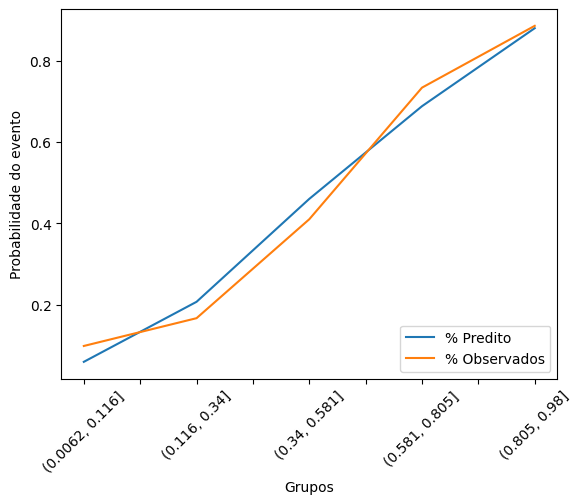

In [367]:
fig = plt.figure()  # Cria uma janela vazia onde se pode desenhar gráficos
ax = fig.add_subplot(1,1,1)  # layout de 1 linha x 1 coluna de subplots, está adicionando o primeiro (e único) subplot nessa figura

ax = new_df_media['new_media_predito'].plot(label='% Predito')
ax = new_df_media['new_media_doente'].plot(label='% Observados')

plt.xticks(rotation=45)
ax.legend(loc='lower right')  # Posição da legenda
ax.set_ylabel('Probabilidade do evento')
ax.set_xlabel('Grupos')

In [379]:
# Acuracidade
acc = metrics.accuracy_score(df['flag_doente'],
                             df['new_predito_model']>.5)

#-------------------------------------------------------------------------------

# Para calcular o gini, primeiramente vou encontrar a curva ROC.
fpr, tpr, threshold = metrics.roc_curve(df['flag_doente'],
                             df['new_predito_model'])
auc_ = metrics.auc(fpr, tpr)
# Com a curva ROC encontrada, basta usar (2*auc_ - 1)
gini = 2*auc_ - 1

#-------------------------------------------------------------------------------

# KS
ks = ks_2samp(df.loc[df['flag_doente']==1,
              'new_predito_model'],
              df.loc[df['flag_doente']!=1,
              'new_predito_model']).statistic

print('Accuracy:{0:.2f}% \nKS:{1:.2f}% \nGini:{2:.2f}%'
      .format(acc*100, ks*100, gini*100))

Accuracy:78.22% 
KS:57.58% 
Gini:70.94%
